In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip3 install mne
%matplotlib inline

     |████████████████████████████████| 6.8MB 6.5MB/s 


In [4]:
import os
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sn

import mne
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)
from mne.decoding import UnsupervisedSpatialFilter

import matplotlib.pyplot as plt

from ipywidgets import interact

from sklearn.decomposition import PCA, FastICA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

from sklearn.externals import joblib

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import sys
sys.path.append('/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/NL_PCA')
from sklearn_nlpca import NLPCA

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [5]:
# Matriz de confusion
def plot_matriz_confusion(y_test, y_predict, labels, save=None, name_fig='fig_1.svg', file_directory='', titulo='Matriz de confusión'):
  
    cm = confusion_matrix(y_test, y_predict)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100

    annot = np.empty_like(cm).astype(np.dtype('U30'))
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d\n' % (p, c, s)
            else:
                annot[i, j] = '%.2f%%\n%d/%d\n' % (p, c, s)
              
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Estimados'
    cm.columns.name = 'Verdaderos'

    fig = plt.figure(figsize = (21,15))
    fig.patch.set_facecolor('White')
    ax = fig.add_subplot(1,1,1)

    ax.set_title(titulo,fontdict={'weight': 'normal','size':20})
    ax.axhline(y=0, color='Black',linewidth=0.2)
    ax.axhline(y=2, color='Black',linewidth=0.2)
    ax.axvline(x=0, color='Black',linewidth=0.2)
    ax.axvline(x=2, color='Black',linewidth=0.2)

    sn.set(font_scale=1.2)  
    sn.heatmap(cm, cmap= "Blues", annot=annot, fmt='', linecolor='Black',linewidths=.1, cbar=None)

    if save==True:
        sns_plot = sn.heatmap(cm, cmap= "Blues", annot=annot, fmt='', linecolor='Black',linewidths=.1, cbar=None)
        fig = sns_plot.get_figure()
        fig.savefig(file_directory+name_fig)
        
# Matriz de confusion con rechazo
def plot_matriz_confusion_rechazo(y_test, y_predict, labels, save=None, name_fig='fig_1.svg', file_directory='', titulo='Matriz de confusión'):
  
    cm = confusion_matrix(y_test, y_predict)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if np.isnan(cm_perc[i][j]):
                cm_perc[i][j]=0
                

    annot = np.empty_like(cm).astype(np.dtype('U30'))
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            else:
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
              
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Estimados'
    cm.columns.name = 'Verdaderos'

    fig = plt.figure(figsize = (7,5))
    fig.patch.set_facecolor('White')
    ax = fig.add_subplot(1,1,1)

    ax.set_title(titulo,fontdict={'weight': 'normal','size':20})
    ax.axhline(y=0, color='Black',linewidth=0.2)
    ax.axhline(y=2, color='Black',linewidth=0.2)
    ax.axhline(y=3, color='Black',linewidth=0.2)
    ax.axvline(x=0, color='Black',linewidth=0.2)
    ax.axvline(x=2, color='Black',linewidth=0.2)
    ax.axvline(x=3, color='Black',linewidth=0.2)

    sn.set(font_scale=1.2)  
    sn.heatmap(cm, cmap= "Blues", annot=annot, fmt='', linecolor='Black',linewidths=.1, cbar=None)

    if save==True:
        sns_plot = sn.heatmap(cm, cmap= "Blues", annot=annot, fmt='', linecolor='Black',linewidths=.1, cbar=None)
        fig = sns_plot.get_figure()
        fig.savefig(file_directory+name_fig)
        
# Seleccion del folder actual
currentFolder = os.getcwd()

In [6]:
# Multichannel Data Visualization
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

def roundNearestTen( n ): 
  
    # Smaller multiple 
    a = (n // 10) * 10
      
    # Larger multiple 
    b = a + 10
      
    # Return of closest of two 
    return (b if n - a > b - n else a) 

def paletteColorPlotlyAlpha (alphaColor=1.0):
    plotlyColors=['rgba(31, 119, 180, '+str(alphaColor)+')', 'rgba(255, 127, 14, '+str(alphaColor)+')',
                  'rgba(44, 160, 44, '+str(alphaColor)+')', 'rgba(214, 39, 40, '+str(alphaColor)+')',
                  'rgba(148, 103, 189, '+str(alphaColor)+')', 'rgba(140, 86, 75, '+str(alphaColor)+')',
                  'rgba(227, 119, 194, '+str(alphaColor)+')', 'rgba(127, 127, 127, '+str(alphaColor)+')',
                  'rgba(188, 189, 34, '+str(alphaColor)+')', 'rgba(23, 190, 207, '+str(alphaColor)+')']
    return plotlyColors

def plotMultiChannelSignal(df, events, sfreq, init, end, title, ylabel, xlabel):
    #print(len(events))
    
    ## Validating init and end
    if init < 0 or init > len(df):
        print('init should be between ['+str(0)+', '+str(len(df))+']')
    if end < 0 or end > len(df):
        print('end should be between ['+str(0)+', '+str(len(df))+']')
        
    Events = events[init:end+1]
    
    timeLine = [val/sfreq for val in range(len(df))]
    timeLine = timeLine[init:end+11]
    
    ## Filtering positions
    dfFiltered = df.iloc[init:end+1]   
    #dfFiltered = dfFiltered[dfFiltered.columns.tolist()[:4]]
    
    ## Getting Symetric closest ten power Ymin, Ymax
    minVal = min([dfFiltered[col].min() for col in dfFiltered.columns.tolist()])
    maxVal = max([dfFiltered[col].max() for col in dfFiltered.columns.tolist()])
    if abs(minVal) > abs(maxVal):
        minVal = -roundNearestTen(abs(minVal))
        maxVal = +roundNearestTen(abs(minVal))
    else:
        minVal = -roundNearestTen(abs(maxVal))
        maxVal = +roundNearestTen(abs(maxVal))
    
    ## Color Palette 
    colorsLine = paletteColorPlotlyAlpha (alphaColor=1.0)
    colorsRect = paletteColorPlotlyAlpha (alphaColor=0.1)
    
    ## Creating array of Scatter data
    data = []
    shapes = []
    annotations = []
    count = len(dfFiltered.columns.tolist())-1
    for col in dfFiltered.columns.tolist():
        x = timeLine
        y = dfFiltered[col].values.tolist()
        yLabels = [col+': '+"{:.3f}".format(val) for val in y]
        y = [(val+((count)*2*maxVal)) for val in y]
        
        trace = go.Scatter(
                        x = x,
                        y = y,
                        text = yLabels,
                        hoverinfo = 'text',
                        name = col,
                        line = dict(
                        color = colorsLine[count % len(colorsLine)],
                        width = 4,)
        )
        data.append(trace)
        
        
        ## Building shapes
        
        if count==len(dfFiltered.columns.tolist())-1:
            minY = minVal
            maxY = maxVal
        else:
            minY = minY + 2*maxVal
            maxY = maxY + 2*maxVal
        
        x0 = x[0]
        x1 = x[-1]
        
        shapes.append(dict(
                            type = 'rect',
                            layer='below',
                            name = col,
                            x0 = x0,
                            y0 = minY,
                            x1 = x1,
                            y1 = maxY,
                            line = dict(
                                    color = colorsRect[count % len(colorsRect)],
                                    width = 1,
                            ),
                            fillcolor = colorsRect[count % len(colorsRect)]
                      )
        )
        
        count -= 1
    
    eventsSet = list(set(Events))
    for i in range(len(Events)):
        if Events[i] != -2:
            #print(str(len(Events))+' - '+ str(i))
            #print(len(timeLine))
            x0 = timeLine[i]
            x1 = timeLine[i+10]
            y0 = minVal
            y1 = y0+(len(dfFiltered.columns.tolist())*2*maxVal)
            indices = [k for k, x in enumerate(eventsSet) if x == Events[i]]
            eventIndex = indices[0]
            shapes.append(dict(
                            type = 'rect',
                            layer='below',
                            name = str(Events[i]),
                            x0 = x0,
                            y0 = y0,
                            x1 = x1,
                            y1 = y1,
                            line = dict(
                                    color = colorsLine[eventIndex % len(colorsLine)],
                                    width = 1,
                            ),
                            fillcolor = colorsLine[eventIndex % len(colorsLine)]
                      )
            )
            annotations.append(dict(
                                x=x0,
                                y=y1,
                                xref='x',
                                yref='y',
                                text=Events[i],
                                font=dict(
                                    size=14,
                                    color=colorsLine[eventIndex % len(colorsLine)]
                                ),
                                showarrow=True,
                                arrowhead=7,
                                ax=0,
                                ay=-20
                        )
            )
            
        
        
    # Edit the layout
    layout = dict(
                  shapes=shapes,
                  annotations = annotations,
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  title = title,
                  xaxis = dict(
                               title = xlabel,
                               showticklabels=True
                  ),
                  yaxis = dict(
                               title = ylabel,
                               showticklabels=False
                  ),
              )

    fig = dict(data=data, layout=layout)
    iplot(fig, filename='MultichannelPlot')

In [7]:
# Return X and y data from Epoched Dataframe
# X: EEG data, in format Ntrials x Nchannels X Nsamples
# y: labels
def getEEGXY(df, channels, columnClass, ColumnEpoch):
  import numpy as np
  classes = df[columnClass].unique()
  X = []
  y = []
  z = df[columnClass].values.tolist()
  for label in classes:
    dfClass = df[df[columnClass]==label]
    epochs = dfClass[ColumnEpoch].unique()
    for epoch in epochs:
      dfEpoch = dfClass[dfClass[ColumnEpoch]==epoch]
      y.append(label)
      X.append(np.transpose(dfEpoch[channels].values))
  return np.stack(X,axis=0), np.array(y), np.array(z).reshape(len(np.stack(X,axis=0)[:,0,0]),len(np.stack(X,axis=0)[0,0,:]))

In [8]:
baseDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/'
trainDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage/RawData/'
subject = '01'
sesion = '01'
task = 'per'
# task = 'img'
path_raw_file = baseDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
path_raw_train = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
filename = 'PERIMG01_0002.vhdr'
filename_sub = 'PERIMG01_sub0002.vmrk'
data_raw_file = path_raw_file  + filename
data_raw_file

'/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/subj01/ses01/per/PERIMG01_0002.vhdr'

In [9]:
eeg_raw = mne.io.read_raw_brainvision(data_raw_file)
print(eeg_raw)
print(eeg_raw.info)

Extracting parameters from /content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/subj01/ses01/per/PERIMG01_0002.vhdr...
Setting channel info structure...
<RawBrainVision | PERIMG01_sub0002.eeg, 63 x 684960 (685.0 s), ~172 kB, data not loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, P7, ...
 chs: 63 EEG
 custom_ref_applied: False
 dig: 63 items (63 EEG)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2018-04-08 10:58:54 UTC
 nchan: 63
 projs: []
 sfreq: 1000.0 Hz
>


In [10]:
channels = eeg_raw.info['ch_names']
Fs = eeg_raw.info['sfreq']

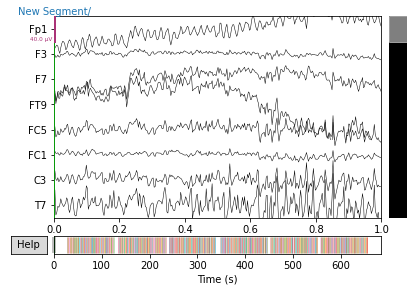

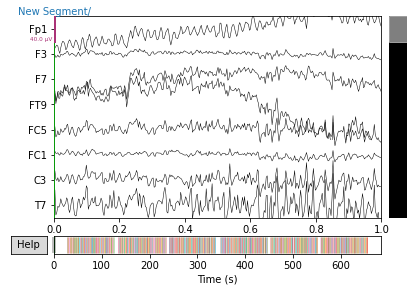

In [11]:
eeg_raw.plot(duration=1, n_channels=8)

In [12]:
print(eeg_raw.annotations)
print(str(len(eeg_raw.annotations))+' Eventos en el archivo')
print('Cada uno de '+str(set(eeg_raw.annotations.duration))+ ' segundos de duración')
print('Tipo de Eventos: ' + str(set(eeg_raw.annotations.description)))
print('El primer evento ocurrió aproximadamente ' + str(eeg_raw.annotations.onset[0]) + ' segundo(s) después de que comenzó la grabación')

<Annotations | 601 segments: New Segment/ (1), Stimulus/S 11 (40), ...>
601 Eventos en el archivo
Cada uno de {0.001} segundos de duración
Tipo de Eventos: {'Stimulus/S 13', 'Stimulus/S 31', 'Stimulus/S 88', 'Stimulus/S 22', 'Stimulus/S 21', 'Stimulus/S 41', 'Stimulus/S 33', 'Stimulus/S 42', 'Stimulus/S 43', 'Stimulus/S 23', 'New Segment/', 'Stimulus/S 11', 'Stimulus/S 32', 'Stimulus/S 12'}
El primer evento ocurrió aproximadamente 0.0 segundo(s) después de que comenzó la grabación


In [13]:
events, event_dict = mne.events_from_annotations(eeg_raw)
print(event_dict)
print(events[:5])

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33', 'Stimulus/S 41', 'Stimulus/S 42', 'Stimulus/S 43', 'Stimulus/S 88']
{'New Segment/': 99999, 'Stimulus/S 11': 11, 'Stimulus/S 12': 12, 'Stimulus/S 13': 13, 'Stimulus/S 21': 21, 'Stimulus/S 22': 22, 'Stimulus/S 23': 23, 'Stimulus/S 31': 31, 'Stimulus/S 32': 32, 'Stimulus/S 33': 33, 'Stimulus/S 41': 41, 'Stimulus/S 42': 42, 'Stimulus/S 43': 43, 'Stimulus/S 88': 88}
[[    0     0 99999]
 [26682     0    41]
 [27716     0    11]
 [28649     0    32]
 [29701     0    88]]


In [14]:
#Reemplazar por nombres de los objetos
#event_dict = {'New Segment/': 99999, 'Apple': 11, 'Carrot': 12, 'Pink': 13, 'Butterfly': 21, 'Chicken': 22, 'Sheep': 23, 'Car': 31, 'Chair': 32, 'Violin': 33,'Ear': 41,'Eye': 42,'Hand': 43,'Rest': 88}
event_dict= {'New Segment/': 99999, 'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43, 'Descanso': 88}

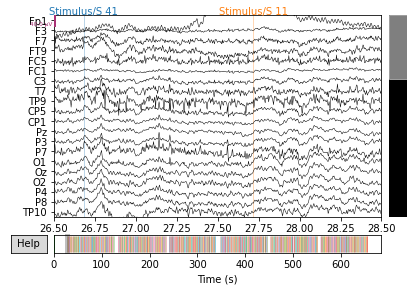

In [15]:
fig = eeg_raw.plot(start=26.5, duration=2)

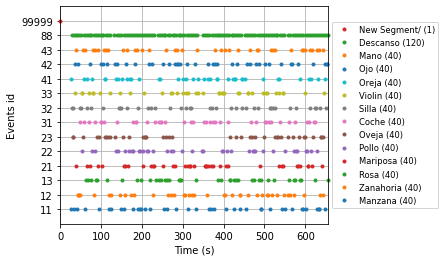

In [16]:
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=eeg_raw.info['sfreq'],
                          first_samp=eeg_raw.first_samp)

In [17]:
#Events = events[:,2]
#print(Events)
reject_criteria = dict(eeg=100e-6)       # 100 µV
tmin, tmax = (-0.1, 0.6)  # epoch from 100 ms before event to 600 ms after it
baseline = (None, 0)      # baseline period from start of epoch to time=0
epochs = mne.Epochs(eeg_raw, events, event_dict, tmin, tmax, proj=True,
                    baseline=baseline, preload=True).resample(250)# Resample of 1000 Hz to 250Hz
print('New sampling rate:', epochs.info['sfreq'], 'Hz')
#del eeg_raw

Not setting metadata
Not setting metadata
601 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 601 events and 701 original time points ...
1 bad epochs dropped
New sampling rate: 250.0 Hz


In [ ]:
# X=epochs.get_data()
# nlpca = UnsupervisedSpatialFilter(NLPCA(30, batch=300, opti_algoritm='adam'), average=False)
# nlpca_data = nlpca.fit_transform(X)
# ev = mne.EvokedArray(np.mean(nlpca_data, axis=0),
#                      mne.create_info(30, epochs.info['sfreq'],
#                                      ch_types='eeg'), tmin=tmin)
# ev.plot(show=False, window_title="NLPCA", time_unit='s')

In [18]:
df = epochs.to_data_frame()
event = [] 
#print(event_dict.values())
for c in df['condition'].values.tolist():
  event.append(event_dict.get(c))
df.insert(2, 'class',event)
df.insert(3, 'event',event)
df = df[df['condition']!='Descanso']
df

,time,condition,class,event,epoch,Fp1,F3,F7,FT9,FC5,FC1,C3,T7,TP9,CP5,CP1,Pz,P3,P7,O1,Oz,O2,P4,P8,TP10,CP6,CP2,Cz,C4,T8,FT10,FC6,FC2,F4,F8,Fp2,AF7,AF3,AFz,F1,F5,FT7,FC3,FCz,C1,C5,TP7,CP3,P1,P5,PO7,PO3,POz,PO4,PO8,P6,P2,CPz,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-100,Oreja,41,41,1,-16.062662,0.813278,0.452799,-2.677223,-2.593201,1.746638,0.337499,-6.865440,13.563579,-1.366674,4.464205,4.891636,1.797178,-0.261919,2.324839,3.077230,0.426985,9.557805,4.766892,7.185249,7.341250,7.291546,4.916808,6.496787,3.796932,4.421076,4.242964,3.767055,-0.986510,-0.703677,1.757997,0.910130,-3.621907,-6.134980,-0.577082,1.444692,-0.322136,0.862463,5.309634,4.359081,-2.586673,3.882309,1.292881,3.755592,0.147606,0.119019,0.322383,5.116514,10.232407,4.965529,6.715605,6.894930,6.420430,7.146658,2.761821,6.048075,6.386711,4.817786,8.787046,-1.484579,-1.453537,-3.751295,5.091690
1,-96,Oreja,41,41,1,-18.520645,1.102348,-2.786601,1.264388,-4.698860,3.481302,3.501675,2.903717,11.082506,0.697853,8.079366,7.893548,2.883881,2.728180,6.372080,6.044479,3.595155,9.368357,6.728233,9.756859,7.398164,8.056129,7.419692,8.377013,1.336614,4.918478,4.651661,4.265335,-1.355518,0.873812,-0.403965,-0.802555,-4.231906,-8.137043,1.420473,1.224251,-0.797410,2.942248,6.961766,5.997886,-0.794275,9.880947,4.283361,5.936642,1.815675,4.972069,4.319497,8.461071,10.322428,6.967782,8.700542,9.377424,9.142520,7.443555,2.451604,7.166097,8.540791,6.143271,14.841636,-0.084042,-0.005542,-4.698773,5.771304
2,-92,Oreja,41,41,1,-18.167127,0.146441,2.586830,-6.119725,3.043130,3.421196,5.619935,-13.885164,6.019688,2.222118,8.718970,8.241855,7.009831,7.174264,8.461891,7.090355,8.541910,9.969037,9.571992,0.937554,9.163783,9.530169,7.127598,10.579287,1.121239,4.876783,2.923942,4.434108,0.089274,2.227320,-4.241691,0.474742,-3.037152,-7.660289,0.770895,-2.308018,3.136651,3.846812,8.477798,6.727276,0.525266,0.232446,6.083805,8.459331,5.263088,8.407777,7.031799,9.666814,11.236721,9.505258,10.009878,10.880815,10.561817,7.824520,2.163502,10.146167,9.727195,6.398045,13.850382,1.857624,0.483287,-3.498203,-0.268845
3,-88,Oreja,41,41,1,-10.638982,-3.781926,-4.111676,-8.453284,-11.572516,-0.663630,-4.280726,-19.277045,-1.090523,-5.248403,0.869446,0.826057,-0.515207,0.583581,-0.980623,-2.884008,0.093345,7.480309,6.393265,-4.678446,4.701538,4.046938,1.588782,2.197825,11.416271,4.389965,-1.718076,0.866923,0.005288,0.516667,-1.404382,-5.047177,-2.424953,-2.154872,-4.037210,-8.256586,-3.584417,-3.696208,2.545279,0.624062,-7.796552,-5.807721,-3.220778,1.445529,-1.353257,-0.396564,-0.804308,1.358179,5.773253,6.440582,7.674662,4.146892,2.299123,4.576909,9.656614,2.298016,3.709291,0.467366,-0.631219,1.186028,-1.340934,-3.818734,-8.159532
4,-84,Oreja,41,41,1,-0.037237,1.442791,-5.576059,-5.370375,-3.116731,-1.395369,-5.779516,-3.787459,-7.693452,-8.185686,-4.950683,-6.049236,-7.208652,-6.569636,-10.357093,-11.630247,-9.501841,-5.859653,-8.150218,-2.663872,-7.136581,-4.409450,-3.019884,-6.535305,2.376934,-0.105986,-8.989681,-1.446273,0.507132,0.062141,6.434247,2.699852,2.944492,5.063639,0.421971,1.309083,-4.785837,-2.849018,-2.072655,-2.268996,-8.109728,-10.421004,-8.735370,-8.398265,-8.162766,-10.548258,-9.446664,-7.548849,-8.050960,-6.625284,-6.358644,-5.156060,-5.292644,-7.317632,0.026098,-6.777662,-3.215047,-3.670767,-8.448937,0.784808,0.099619,1.266241,-2.725287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104820,580,Rosa,13,13,599,-6.345102,-0.065388,-6.006503,-0.175400,-3.361062,3.014781,-4.801219,-3.799906,-36.437082,-8.538352,-5.630884,-9.963250,-10.664928,-19.634854,-16.174985,-19.279338,-10.688027,-12.205545,-12.475906,-16.621580,-7.121742,-3.517044,0.781113,-6.792799,-9.086572,-13.763138,-9.595021,1.036438,1.955781,-8.110246,-0.069213,-17.662966,1.041963,-2.588882,0.215913,0.59

In [ ]:
df_per = epochs.to_data_frame()
per_dict= {'New Segment/': 1, 'Manzana': 1, 'Zanahoria': 1, 'Rosa': 1, 'Mariposa': 1, 'Pollo': 1, 'Oveja': 1, 'Coche': 1, 'Silla': 1, 'Violin': 1, 'Oreja': 1, 'Ojo': 1, 'Mano': 1, 'Descanso': 0}
event = [] 
#print(event_dict.values())
for c in df_per['condition'].values.tolist():
  event.append(per_dict.get(c))
df_per.insert(2, 'class',event)
df_per.insert(3, 'event',event)
df_per

In [ ]:
Events = df['event'].values.tolist()
EventsProcessed = []
last = ''
firstime = True
for ev in Events:
  if firstime == True:
    EventsProcessed.append(ev)
    firstime = False
    last = ev
    continue
  if ev == last:
    EventsProcessed.append(-2.0)
  else:
    EventsProcessed.append(ev)
  last = ev  
print(len(Events))
print(len(EventsProcessed))

84000
84000


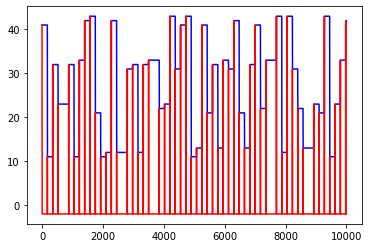

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(Events[:10000],'b-')
plt.plot(EventsProcessed[:10000],'r-')
plt.show()

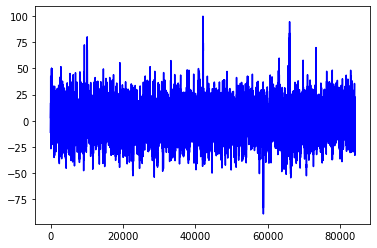

In [ ]:
Signal = df['Oz'].values.tolist()
plt.plot(Signal,'b-')

In [ ]:
df['event'] = EventsProcessed
df.iloc[170:180]

In [ ]:
classes_names = list(df['condition'].unique())
print(classes_names)

['Oreja', 'Manzana', 'Silla', 'Oveja', 'Violin', 'Ojo', 'Mano', 'Mariposa', 'Zanahoria', 'Coche', 'Pollo', 'Rosa']


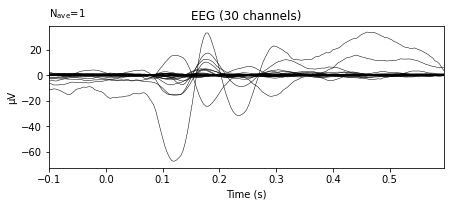

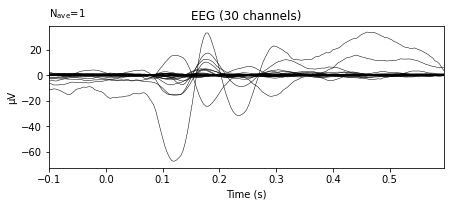

In [ ]:
X=epochs.get_data()
pca = UnsupervisedSpatialFilter(PCA(30), average=False)
pca_data = pca.fit_transform(X)
ev = mne.EvokedArray(np.mean(pca_data, axis=0),
                     mne.create_info(30, epochs.info['sfreq'],
                                     ch_types='eeg'), tmin=tmin)
ev.plot(show=False, window_title="PCA", time_unit='s')

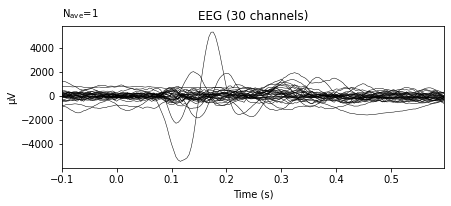

In [ ]:
ica = UnsupervisedSpatialFilter(FastICA(30), average=False)
ica_data = ica.fit_transform(X)
ev1 = mne.EvokedArray(np.mean(ica_data, axis=0),
                      mne.create_info(30, epochs.info['sfreq'],
                                      ch_types='eeg'), tmin=tmin)
ev1.plot(show=False, window_title='ICA', time_unit='s')

plt.show()

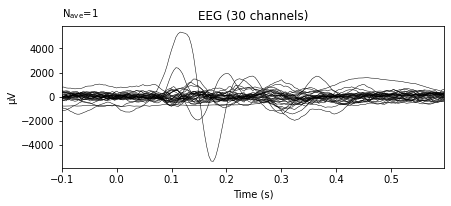

In [ ]:
ica = UnsupervisedSpatialFilter(FastICA(30), average=False)
ica_data = ica.fit_transform(pca_data)
ev1 = mne.EvokedArray(np.mean(ica_data, axis=0),
                      mne.create_info(30, epochs.info['sfreq'],
                                      ch_types='eeg'), tmin=tmin)
ev1.plot(show=False, window_title='ICA', time_unit='s')

plt.show()

In [ ]:
X=epochs.get_data()
pca_lineal = PCA(n_components=30)
n_epochs, n_channels, n_times = X.shape
# trial as time samples
X = np.transpose(X, (1, 0, 2)).reshape((n_channels, n_epochs*n_times)).T
pca_lineal.fit(X)
percent_pc = pca_lineal.explained_variance_ratio_

# percent_pc=percent_pc*100
# percent_pc=(np.round(percent_pc*100))/100
# print('Total Explained variance for linear PC:',sum(percent_pc),'%')
# print('Explained variance (see: net.variance)\n')
# for i in range(30):
#   print('linear PC ',i+1,': ',percent_pc[i],'%')

(pca_lineal.explained_variance_).shape

In [ ]:
## Getting Trial representation for Python Pipelines
X, y, z = getEEGXY(df=df, channels=channels, columnClass='class', ColumnEpoch='epoch')
print("Shape X original: "+str(X.shape))
print("Shape y original: "+str(y.shape))
print("Shape z original: "+str(z.shape))
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.25, random_state=42)
print("Shape X train: "+str(X_train.shape))
print("Shape y train: "+str(y_train.shape))
print("Shape z train: "+str(z_train.shape))
print("Shape X test: "+str(X_test.shape))
print("Shape y test: "+str(y_test.shape))
print("Shape z test: "+str(z_test.shape))
xx_list = []
yy_list = []
for e in range(len(X_train[:,0,0])):
  xx_list.append(X_train[e,:,:])
  yy_list.append(z_train[e,:])
xx_train = np.transpose(np.concatenate(xx_list, axis=1))
yy_train = np.transpose(np.concatenate(yy_list, axis=0))
print("Shape xx_train: "+str(xx_train.shape))
print("Shape yy_train: "+str(yy_train.shape))

xx_list = []
for e in range(len(X_test[:,0,0])):
  xx_list.append(X_test[e,:,:])
xx_test = np.transpose(np.concatenate(xx_list, axis=1))
print("Shape xx_test: "+str(xx_test.shape))

vect = Vectorizer()
vect.fit(np.moveaxis(X_train,0,-2), y_train)
xx_train = np.transpose(vect.transform(np.moveaxis(X_train,0,-2)))
xx_train.shape

In [ ]:
pca_lineal = PCA(n_components=3)
pca_lineal.fit(xx_train)
percent_pc = pca_lineal.explained_variance_ratio_

percent_pc=percent_pc*100
percent_pc=(np.round(percent_pc*100))/100
print('Total Explained variance for linear PC:',sum(percent_pc),'%')
print('Explained variance (see: net.variance)\n')
for i in range(3):
  print('linear PC ',i+1,': ',percent_pc[i],'%')

In [ ]:
# EEG_nlpca=nlpca(xx_train,3,pre_pca=False, weight_initialization='linear')
# EEG_nlpca.fit(max_iteration=100, batch=400, verbose=1, callbacks=True, callbacks_path=path_raw_train, opti_algoritm='adam')
# EEG_nlpca.save(path_raw_train +'train_3components_tanh_adam', mode='h5')

# Total Explained variance for nonlinear PC: 83.0 %
# Explained variance (see: net.variance)

# nonlinear PC  1 :  63.33 %
# nonlinear PC  2 :  12.96 %
# nonlinear PC  3 :  5.88 %

In [ ]:
EEG_nlpca=nlpca(xx_train,3)
EEG_nlpca.load(path_raw_train +'train_3components_tanh_adam', mode='h5')

In [ ]:
# Estimate explained variance of each nonlinear component

total_variance=sum(np.var(xx_train, axis=0))
#print(total_variance)

pc=EEG_nlpca.get_components(xx_train)
evals=np.zeros(3)

data_recon_total=EEG_nlpca.get_data(pc)
evals_total=sum(np.var(data_recon_total, axis=0))
#print(evals_total)

percentVar_recon=(evals_total/total_variance)*100;
percentVar_recon=(np.round(percentVar_recon*100))/100
print('Total Explained variance for nonlinear PC:',percentVar_recon,'%')

for i in range(3):
  pcx=np.zeros(pc.shape)
  pcx[:,i] = pc[:,i] #only PC_i, set remaining PC's to zero
  data_recon=EEG_nlpca.get_data(pcx)
  evals[i]=sum(np.var(data_recon, axis=0)) 

#print(evals)
percentVar=(evals/total_variance)*100;
#print(percentVar)
percentVar=(np.round(percentVar*100))/100
#print(percentVar)
print('Explained variance (see: net.variance)\n')
for i in range(3):
  print('nonlinear PC ',i+1,': ',percentVar[i],'%')

In [ ]:
Xc=EEG_nlpca.get_components(xx_train)*20

X_MIN = Xc[:,0].min()-1
X_MAX = Xc[:,0].max()+1
Y_MIN = Xc[:,1].min()-1
Y_MAX = Xc[:,1].max()+1
Z_MIN = Xc[:,2].min()-1
Z_MAX = Xc[:,2].max()+1

#group = y_train.replace([3, 2, 4, 1, 0, 6], [1, 2, 3, 5, 4, 6])

def plot_3D(elev=13, azim=55):
 
    plt.figure(figsize=(20,10))
    ax = plt.subplot(projection='3d')
    b1 = ax.scatter3D(Xc[:, 0], Xc[:, 1], Xc[:, 2], c=z_train, s=10, cmap='hot')
    ax.view_init(elev=elev, azim=azim)
    # Some presentation tweaks
    ax.set_xlim((X_MIN, X_MAX))
    ax.set_ylim((Y_MIN, Y_MAX))
    ax.set_zlim((Z_MIN, Z_MAX))

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    

interact(plot_3D, elev=(0, 360), azim=(0, 360));

In [ ]:
Xc=EEG_nlpca.get_components(xx_train)
Xt=EEG_nlpca.get_components(xx_test)
X_train_nlpca = np.float64(np.array(np.split(np.transpose(Xc),len(X_train), 1)))
X_test_nlpca = np.float64(np.array(np.split(np.transpose(Xt),len(X_test), 1)))
# X_train_nlpca = np.mean(X_train_nlpca, axis= 2)
# X_train_nlpca = np.mean(X_train, axis= 2)
X_test_nlpca.shape


In [ ]:
#pca = UnsupervisedSpatialFilter(PCA(8), average=False)
pca = PCA(n_components=3)
csp = CSP(n_components=40, reg=0.01, log = True, norm_trace=False, transform_into='average_power', rank=None) # log = True
Nb = GaussianNB()
lda = LinearDiscriminantAnalysis()
clf = make_pipeline(csp, pca, lda)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

plot_matriz_confusion(y_test, y_predict, classes_names)

In [ ]:
#Visulaizar percepción vs descnaso
Xp, yp, zp = getEEGXY(df=df_per, channels=channels, columnClass='class', ColumnEpoch='epoch')

names = ["Nearest Neighbors", "Logistic Regression", "Linear SVM", "Naive Bayes", "LDA", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(solver='lbfgs'),
    SVC(kernel="linear", C=0.025),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

for name, estimator in zip(names, classifiers):
  # We will train the classifier on  visual vs null trials on EEG
  clf = make_pipeline(StandardScaler(), estimator)

  time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
  scores = cross_val_multiscore(time_decod, Xp, yp, cv=4, n_jobs=1)

  # Mean scores across cross-validation splits
  scores = np.mean(scores, axis=0)

  # Plot
  fig, ax = plt.subplots()
  ax.plot(epochs.times, scores, label='score')
  ax.axhline(.5, color='k', linestyle='--', label='chance')
  ax.set_xlabel('Times')
  ax.set_ylabel('AUC')  # Area Under the Curve
  ax.legend()
  ax.axvline(.0, color='k', linestyle='-')
  ax.set_title('Sensor space decoding from '+name)


In [ ]:
#Visulaizar percepción vs descnaso CON PCA
Xp, yp, zp = getEEGXY(df=df_per, channels=channels, columnClass='class', ColumnEpoch='epoch')

pca = PCA(n_components=3)
csp = CSP(n_components=40, reg=0.01, log = True, norm_trace=False, transform_into='average_power', rank=None) # log = True

names = ["Nearest Neighbors", "Logistic Regression", "Linear SVM", "Naive Bayes", "LDA", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(solver='lbfgs'),
    SVC(kernel="linear", C=0.025),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

for name, estimator in zip(names, classifiers):
  # We will train the classifier on  visual vs null trials on EEG
  clf = make_pipeline(pca, estimator)

  time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
  scores = cross_val_multiscore(time_decod, Xp, yp, cv=4, n_jobs=1)

  # Mean scores across cross-validation splits
  scores = np.mean(scores, axis=0)

  # Plot
  fig, ax = plt.subplots()
  ax.plot(epochs.times, scores, label='score')
  ax.axhline(.5, color='k', linestyle='--', label='chance')
  ax.set_xlabel('Times')
  ax.set_ylabel('AUC')  # Area Under the Curve
  ax.legend()
  ax.axvline(.0, color='k', linestyle='-')
  ax.set_title('Sensor space decoding from '+name)

In [ ]:
#Visulaizar percepción vs descnaso CON NLPA
Xp, yp, zp = getEEGXY(df=df_per, channels=channels, columnClass='class', ColumnEpoch='epoch')

vect = Vectorizer()
vect.fit(np.moveaxis(Xp,0,-2), yp)
xx_p = np.transpose(vect.transform(np.moveaxis(Xp,0,-2)))

Xcp=EEG_nlpca.get_components(xx_p)
Xp = np.float64(np.array(np.split(np.transpose(Xcp),len(Xp), 1)))

csp = CSP(n_components=40, reg=0.01, log = True, norm_trace=False, transform_into='average_power', rank=None) # log = True

names = ["Nearest Neighbors", "Logistic Regression", "Linear SVM", "Naive Bayes", "LDA", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(solver='lbfgs'),
    SVC(kernel="linear", C=0.025),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

for name, estimator in zip(names, classifiers):
  # We will train the classifier on  visual vs null trials on EEG
  clf = make_pipeline(StandardScaler(), estimator)

  time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
  scores = cross_val_multiscore(time_decod, Xp, yp, cv=4, n_jobs=1)

  # Mean scores across cross-validation splits
  scores = np.mean(scores, axis=0)

  # Plot
  fig, ax = plt.subplots()
  ax.plot(epochs.times, scores, label='score')
  ax.axhline(.5, color='k', linestyle='--', label='chance')
  ax.set_xlabel('Times')
  ax.set_ylabel('AUC')  # Area Under the Curve
  ax.legend()
  ax.axvline(.0, color='k', linestyle='-')
  ax.set_title('Sensor space decoding from '+name)

In [ ]:
Xp, yp, zp = getEEGXY(df=df_per, channels=channels, columnClass='class', ColumnEpoch='epoch')

set_scores = []

names = ["Nearest Neighbors", "Logistic Regression", "Linear SVM", "Naive Bayes", "LDA", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(solver='lbfgs'),
    SVC(kernel="linear", C=0.025),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]
    
# define the Temporal generalization object
for name, estimator in zip(names, classifiers):
  # We will train the classifier on  visual vs null trials on EEG
  clf = make_pipeline(StandardScaler(), estimator)

  time_gen = GeneralizingEstimator(clf, n_jobs=-1, scoring='roc_auc',
                                 verbose=True)

  scores = cross_val_multiscore(time_gen, Xp, yp, cv=4, n_jobs=-1)

  print(scores.shape)

  # Mean scores across cross-validation splits
  scores = np.mean(scores, axis=0)
  set_scores.append(scores)

  # Plot the diagonal (it's exactly the same as the time-by-time decoding above)
  fig, ax = plt.subplots()
  ax.plot(epochs.times, np.diag(scores), label='score')
  ax.axhline(.5, color='k', linestyle='--', label='chance')
  ax.set_xlabel('Times')
  ax.set_ylabel('AUC')
  ax.legend()
  ax.axvline(.0, color='k', linestyle='-')
  ax.set_title('Decoding EEG sensors over time from '+name)

In [ ]:
for score, name in zip(set_scores, names):
  fig, ax = plt.subplots(1, 1)
  im = ax.imshow(score, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=epochs.times[[0, -1, 0, -1]], vmin=0., vmax=1.)
  ax.set_xlabel('Testing Time (s)')
  ax.set_ylabel('Training Time (s)')
  ax.set_title('Temporal generalization from '+ name)
  ax.axvline(0, color='k')
  ax.axhline(0, color='k')
  plt.colorbar(im, ax=ax)

In [ ]:
Xp, yp, zp = getEEGXY(df=df_per, channels=channels, columnClass='class', ColumnEpoch='epoch')

vect = Vectorizer()
vect.fit(np.moveaxis(Xp,0,-2), yp)
xx_p = np.transpose(vect.transform(np.moveaxis(Xp,0,-2)))

Xcp=EEG_nlpca.get_components(xx_p)
Xp = np.float64(np.array(np.split(np.transpose(Xcp),len(Xp), 1)))

set_scores = []

names = ["Nearest Neighbors", "Logistic Regression", "Linear SVM", "Naive Bayes", "LDA", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(solver='lbfgs'),
    SVC(kernel="linear", C=0.025),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]
    
# define the Temporal generalization object ft NLPCA
for name, estimator in zip(names, classifiers):
  # We will train the classifier on  visual vs null trials on EEG
  clf = make_pipeline(StandardScaler(), estimator)

  time_gen = GeneralizingEstimator(clf, n_jobs=-1, scoring='roc_auc',
                                 verbose=True)

  scores = cross_val_multiscore(time_gen, Xp, yp, cv=4, n_jobs=-1)

  # Mean scores across cross-validation splits
  scores = np.mean(scores, axis=0)
  set_scores.append(scores)

  # Plot the diagonal (it's exactly the same as the time-by-time decoding above)
  fig, ax = plt.subplots()
  ax.plot(epochs.times, np.diag(scores), label='score')
  ax.axhline(.5, color='k', linestyle='--', label='chance')
  ax.set_xlabel('Times')
  ax.set_ylabel('AUC')
  ax.legend()
  ax.axvline(.0, color='k', linestyle='-')
  ax.set_title('Decoding EEG sensors over time from '+name)

In [ ]:
for score, name in zip(set_scores, names):
  fig, ax = plt.subplots(1, 1)
  im = ax.imshow(score, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=epochs.times[[0, -1, 0, -1]], vmin=0., vmax=1.)
  ax.set_xlabel('Testing Time (s)')
  ax.set_ylabel('Training Time (s)')
  ax.set_title('Temporal generalization ft NLPCA from '+ name)
  ax.axvline(0, color='k')
  ax.axhline(0, color='k')
  plt.colorbar(im, ax=ax)


(480, 63, 175)
(4, 175)



(480, 63, 175)
(4, 175)



(480, 63, 175)
(4, 175)


KeyboardInterrupt: ignored

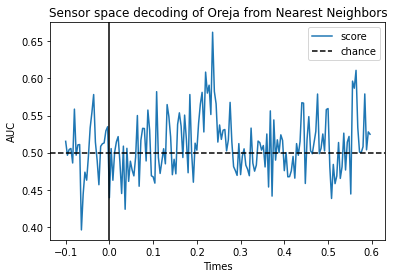

Error in callback <function flush_figures at 0x7f52514fc2f0> (for post_execute):


KeyboardInterrupt: ignored

In [20]:
#Visulaizar percepción de los 12 objetos
X, y, z = getEEGXY(df=df, channels=channels, columnClass='class', ColumnEpoch='epoch')

classes = list(df['class'].unique())
y = label_binarize(y, classes=classes)
n_classes = y.shape[1]

classes_names = list(df['condition'].unique())

names = ["Nearest Neighbors", "Logistic Regression", "Linear SVM", "Naive Bayes", "LDA", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(solver='lbfgs'),
    SVC(kernel="linear", C=0.025),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

for name, estimator in zip(names, classifiers):
  for i, c in zip (range(n_classes), classes_names):
    # We will train the classifier on  visual vs null trials on EEG
    clf = make_pipeline(StandardScaler(), estimator)

    time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
    scores = cross_val_multiscore(time_decod, X, y[:,i], cv=4, n_jobs=1)
    print(X.shape)
    print(scores.shape)
    # Mean scores across cross-validation splits
    scores = np.mean(scores, axis=0)

    # Plot
    fig, ax = plt.subplots()
    ax.plot(epochs.times, scores, label='score')
    ax.axhline(.5, color='k', linestyle='--', label='chance')
    ax.set_xlabel('Times')
    ax.set_ylabel('AUC')  # Area Under the Curve
    ax.legend()
    ax.axvline(.0, color='k', linestyle='-')
    ax.set_title('Sensor space decoding of '+ c +' from '+ name)

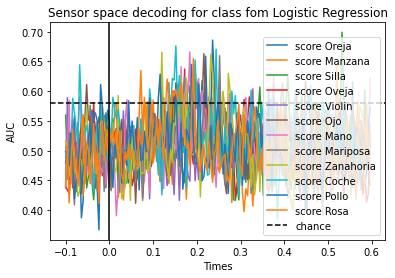

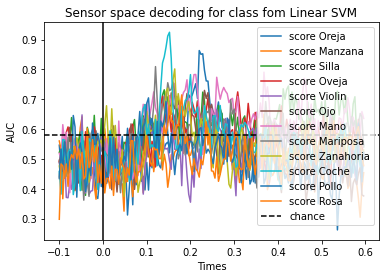

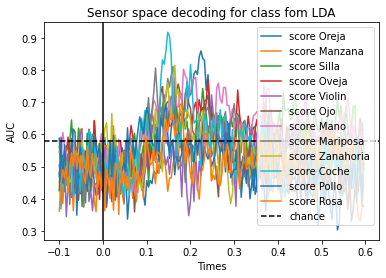

In [ ]:
#Visulaizar percepción de los 12 objetos
X, y, z = getEEGXY(df=df, channels=channels, columnClass='class', ColumnEpoch='epoch')

classes = list(df['class'].unique())
y = label_binarize(y, classes=classes)
n_classes = y.shape[1]

classes_names = list(df['condition'].unique())

names = ["Logistic Regression", "Linear SVM", "LDA"]

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(solver='lbfgs'),
    SVC(kernel="linear", C=0.025),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]


for name, estimator in zip(names, classifiers):
  scores_class = []
  for i, c in zip (range(n_classes), classes_names):
    # We will train the classifier on  visual vs null trials on EEG
    clf = make_pipeline(estimator)

    time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
    scores = cross_val_multiscore(time_decod, X, y[:,i], cv=4, n_jobs=1)

    # Mean scores across cross-validation splits
    scores = np.mean(scores, axis=0)
    scores_class.append(scores)

  # Plot
  fig, ax = plt.subplots()
  for s, c in zip(scores_class, classes_names):
    ax.plot(epochs.times, s, label='score '+c)
  ax.axhline(.58, color='k', linestyle='--', label='chance')
  ax.set_xlabel('Times')
  ax.set_ylabel('AUC')  # Area Under the Curve
  ax.legend()
  ax.axvline(.0, color='k', linestyle='-')
  ax.set_title('Sensor space decoding for class fom '+ name)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   4 | elapsed:  6.1min remaining:  6.1min
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed: 12.1min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed: 12.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


(4, 175, 175)


[Parallel(n_jobs=2)]: Done   2 out of   4 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:  1.2min remaining:    0.0s


KeyboardInterrupt: ignored

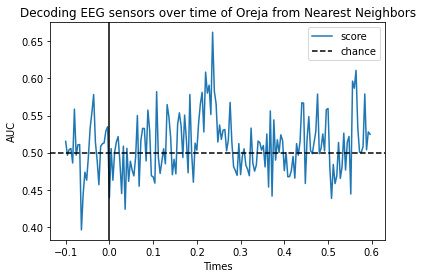

In [22]:
#Visualizar Generalización Temporal para percepción de los 12 objetos
X, y, z = getEEGXY(df=df, channels=channels, columnClass='class', ColumnEpoch='epoch')

classes = list(df['class'].unique())
y = label_binarize(y, classes=classes)
n_classes = y.shape[1]

classes_names = list(df['condition'].unique())

names = ["Nearest Neighbors", "Logistic Regression", "Linear SVM", "Naive Bayes", "LDA", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(solver='lbfgs'),
    SVC(kernel="linear", C=0.025),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

set_scores=[]

for name, estimator in zip(names, classifiers):
  for i, c in zip (range(n_classes), classes_names):
    # We will train the classifier on  visual vs null trials on EEG
    clf = make_pipeline(StandardScaler(), estimator)

    time_gen = GeneralizingEstimator(clf, n_jobs=-1, scoring='roc_auc',
                                 verbose=True)

    scores = cross_val_multiscore(time_gen, X, y[:,i], cv=4, n_jobs=-1)
    print(scores.shape)

    # Mean scores across cross-validation splits
    scores = np.mean(scores, axis=0)
    set_scores.append(scores)

    # Plot the diagonal (it's exactly the same as the time-by-time decoding above)
    fig, ax = plt.subplots()
    ax.plot(epochs.times, np.diag(scores), label='score')
    ax.axhline(.5, color='k', linestyle='--', label='chance')
    ax.set_xlabel('Times')
    ax.set_ylabel('AUC')
    ax.legend()
    ax.axvline(.0, color='k', linestyle='-')
    ax.set_title('Decoding EEG sensors over time of '+ c +' from '+ name)

In [ ]:
# Define channels and time interval of interest to visualize
channelsOfInterest = ['Pz','P3','P7','O1','Oz','O2','P4','P8','P1','P5','PO7','PO3','POz','PO4','PO8','P6','P2','C3']
init = round(0.8*len(df)) # from 0% of signal length
end = round(0.85*len(df)) # to 100% of signal length

In [ ]:
plotMultiChannelSignal(df=df[channelsOfInterest], events=df['event'].values.tolist(), 
                       sfreq=Fs, init=init, end=end, title='Multichannel Biosignal', 
                       ylabel='Amplitude', xlabel='Time (s)')